In [1]:
# import datasets
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
import time
import pathlib
import os.path

## Fetch Harvard Oxford Atlas

In [2]:
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

In [3]:
# %%
# Function to find all the regressor file paths
def timer(func):
    """Print the runtime of the decorated function"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        print(f'Calling {func.__name__!r}')
        startTime = time.perf_counter()
        value = func(*args, **kwargs)
        endTime = time.perf_counter()
        runTime = endTime - startTime
        print(f'Finished {func.__name__!r} in {runTime:.4f} secs')
        return value
    return wrapper

# %%
# Function to find all file paths
@timer
def find_paths(relDataFolder, subj, sess, func, patt):
    paths = list(pathlib.Path(relDataFolder).glob(
                        os.path.join(subj, sess, func, patt)
                    )
                )
                        
    return paths

In [4]:
# %%
# Find all the BOLD NII file paths
nii_paths = find_paths(relDataFolder='../data/preprocessed',
                        subj='sub-*',
                        sess='ses-*',
                        func='func',
                        patt="*MNI152NLin2009cAsym_desc-preproc_bold.nii.gz")
nii_paths

Calling 'find_paths'
Finished 'find_paths' in 0.0013 secs


[WindowsPath('../data/preprocessed/sub-9001/ses-1/func/sub-9001_ses-1_task-arrows_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-1/func/sub-9001_ses-1_task-faces_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-1/func/sub-9001_ses-1_task-hands_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-1/func/sub-9001_ses-1_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-1/func/sub-9001_ses-1_task-sleepiness_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-2/func/sub-9001_ses-2_task-arrows_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-2/func/sub-9001_ses-2_task-faces_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'),
 WindowsPath('../data/preprocessed/sub-9001/ses-2

## Confounds Regressors Fill NaNs

In [5]:
#df_confounds_regressors = pd.read_csv(faces_confounds_regressors_path, sep="\t")
#df_confounds_regressors

In [6]:
#column_means = df_confounds_regressors.mean()
#df_confounds_regressors_fill_na = df_confounds_regressors.fillna(column_means)
#df_confounds_regressors_zero_for_nan = df_confounds_regressors.fillna(0)


In [7]:
#df_confounds_regressors_fill_na.to_csv(no_nan_faces_confounds_regressors_path, sep="\t")
#df_confounds_regressors_zero_for_nan.to_csv(zero_for_nan_faces_confounds_regressors_path, sep="\t")

## Use NiftiLabelMasker

In [8]:
time_series_list = []
groups = [] # session 1 or session 2 

In [9]:
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

#masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache', memory_level=1, verbose=0)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction

#time_series = masker.fit_transform(arrows_slices_file_path, confounds=no_nan_arrows_confounds_regressors_path)
#time_series = masker.fit_transform(arrows_slices_file_path, confounds=zero_for_nan_arrows_confounds_regressors_path)

for nii_path in nii_paths:
    time_series = masker.fit_transform(nii_path.__str__())
    time_series_list.append(time_series)
    
    if "ses-1" in nii_path.__str__():
        groups.append("ses-1")
    else:
        groups.append("ses-2")

[NiftiLabelsMasker.fit_transform] loading data from C:\Users\alexf/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.1s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from C:\Users\alexf/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
[Memory]3.5s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from C:\Users\alexf/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
[Memory]7.5s, 0.1min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] loading data from C:\Users\alexf/nilearn_data\fsl\data\atlases\HarvardOx

In [10]:
time_series_list

[array([[-0.62964192,  0.03616337, -1.558188  , ...,  0.37831482,
          1.0365072 ,  0.3271332 ],
        [-1.31042979, -0.46313304, -1.72457155, ...,  0.34626531,
          1.72717018,  0.4516337 ],
        [-1.41410107, -0.87741906, -1.55282198, ..., -0.13433685,
          1.86002595,  0.99688911],
        ...,
        [ 0.58939114,  0.87219455,  0.96226281, ..., -0.86009319,
         -2.10402563, -1.93483023],
        [ 0.12788566, -0.59381441,  0.8208829 , ..., -0.89008503,
         -0.76556153, -0.44553725],
        [ 0.16839316,  0.02250815,  0.9700867 , ..., -0.71804349,
         -0.39379672,  0.2293457 ]]),
 array([[-0.75171737,  0.92207221, -1.42855052, ...,  0.86515468,
          0.99199082, -0.01146766],
        [-0.31210322,  0.59929243, -1.18841715, ...,  0.57684235,
          1.21484885,  0.52237239],
        [ 0.14117005, -0.19738972, -0.90884032, ...,  0.85701441,
          0.3020157 ,  0.77262479],
        ...,
        [ 1.19067687,  1.43073629,  0.03772999, ..., -

In [11]:
groups

['ses-1',
 'ses-1',
 'ses-1',
 'ses-1',
 'ses-1',
 'ses-2',
 'ses-2',
 'ses-2',
 'ses-2',
 'ses-2']

## Compute and Display a correlation matrix

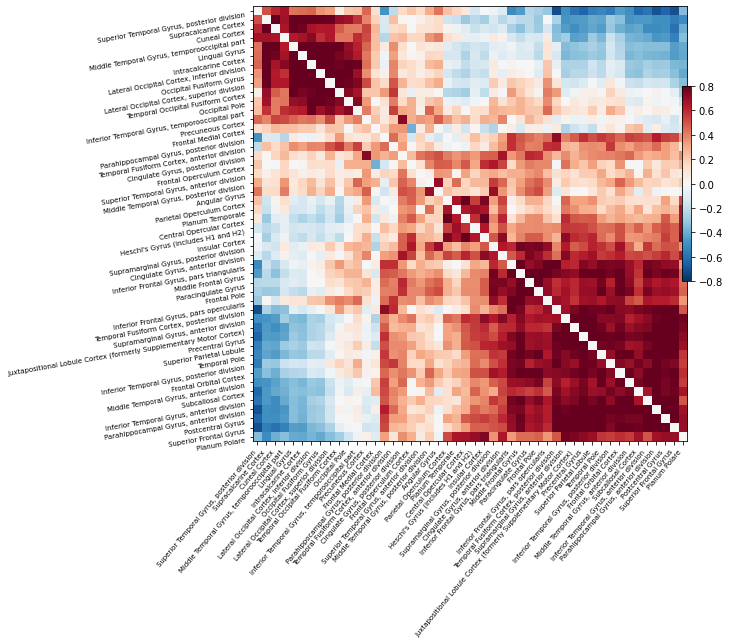

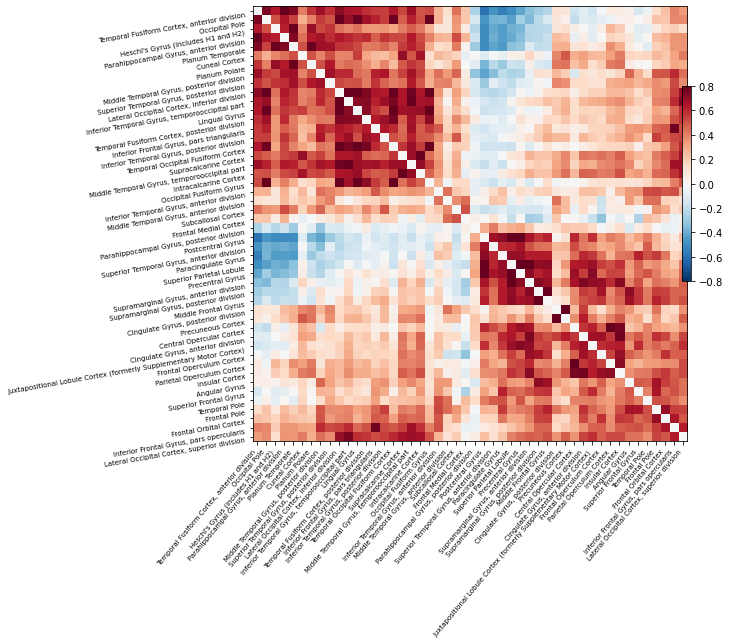

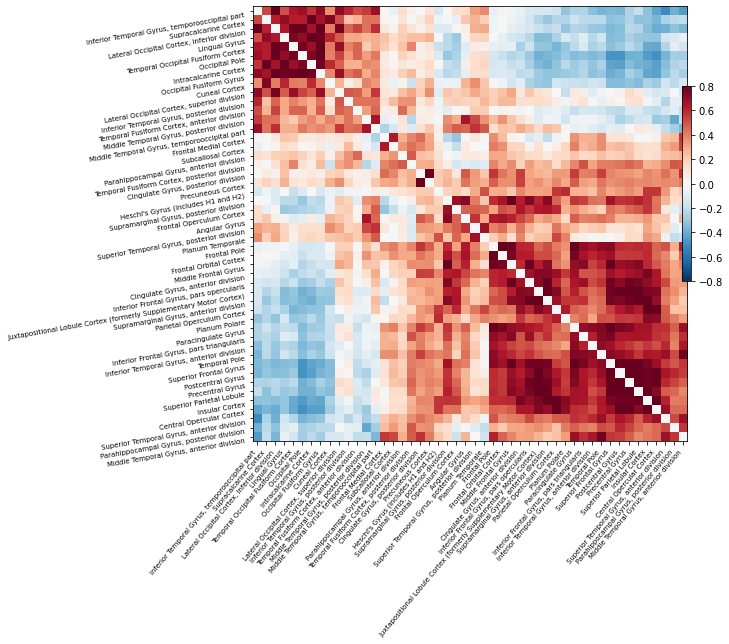

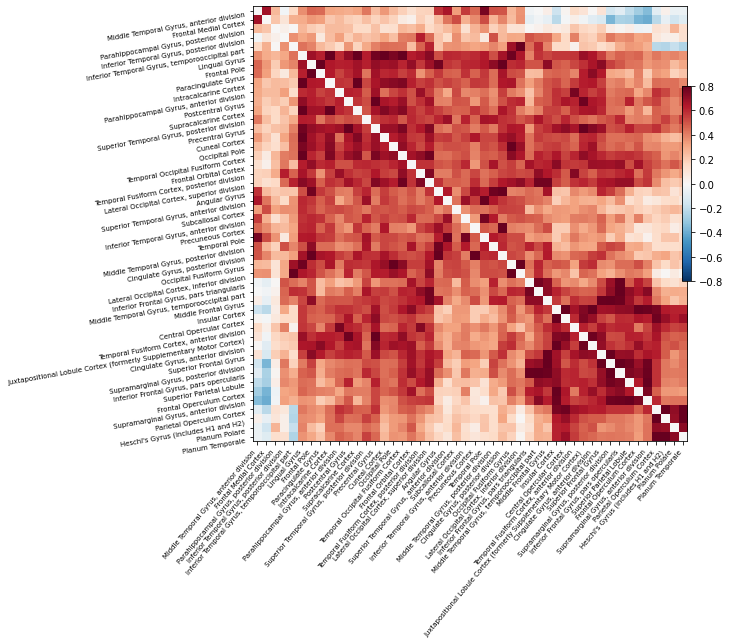

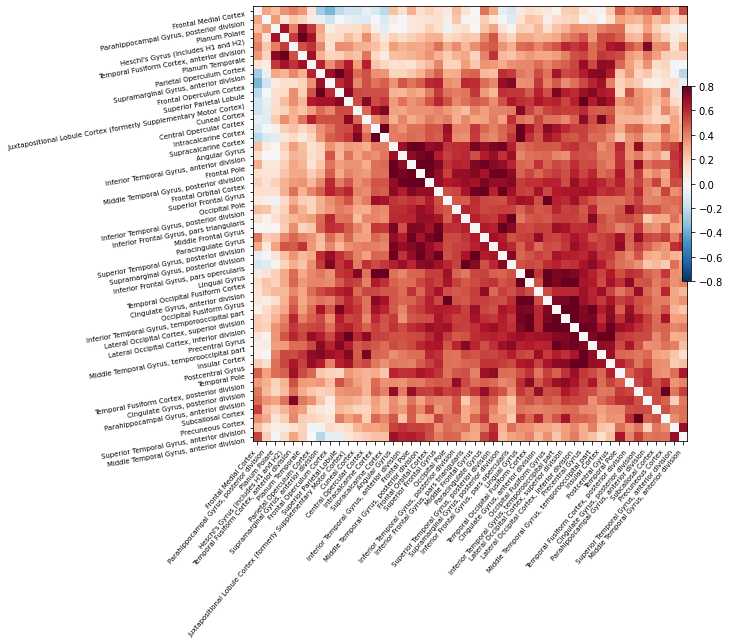

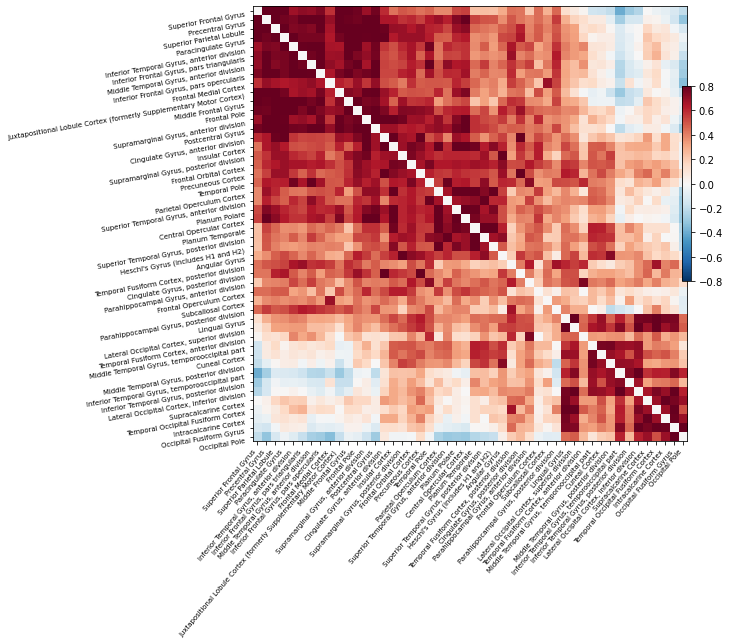

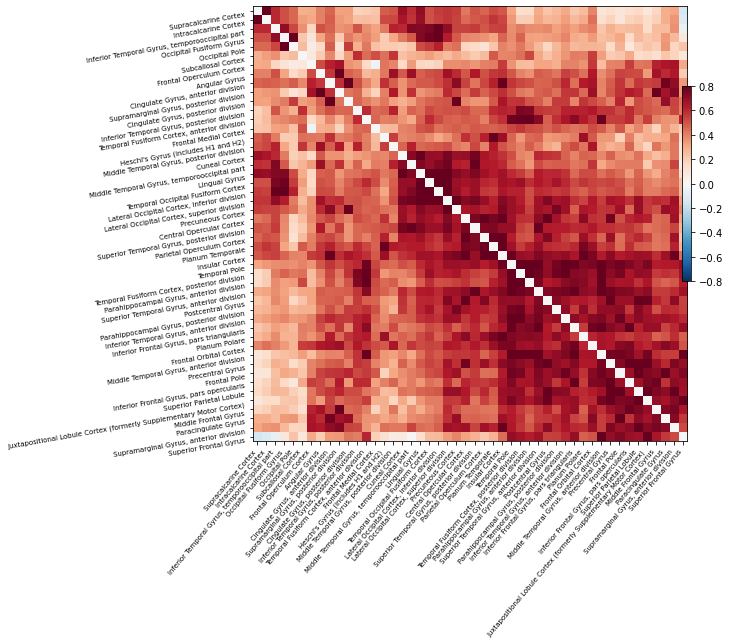

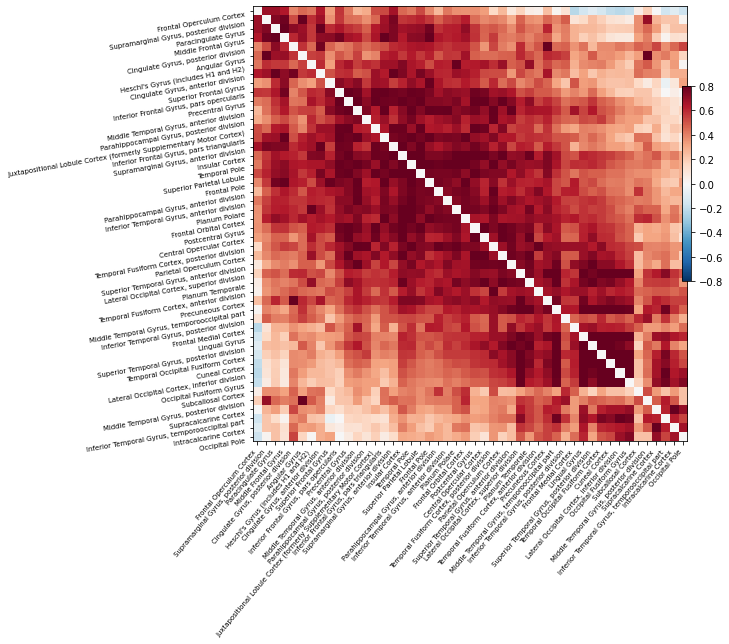

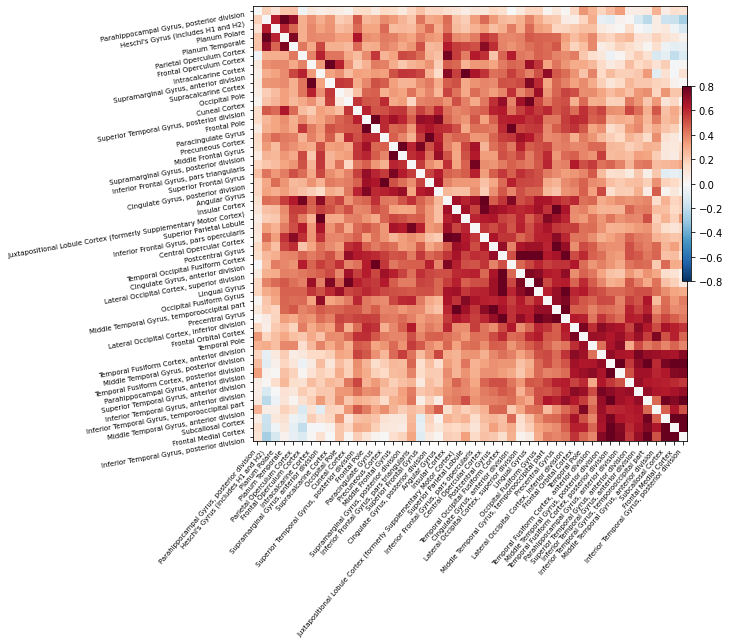

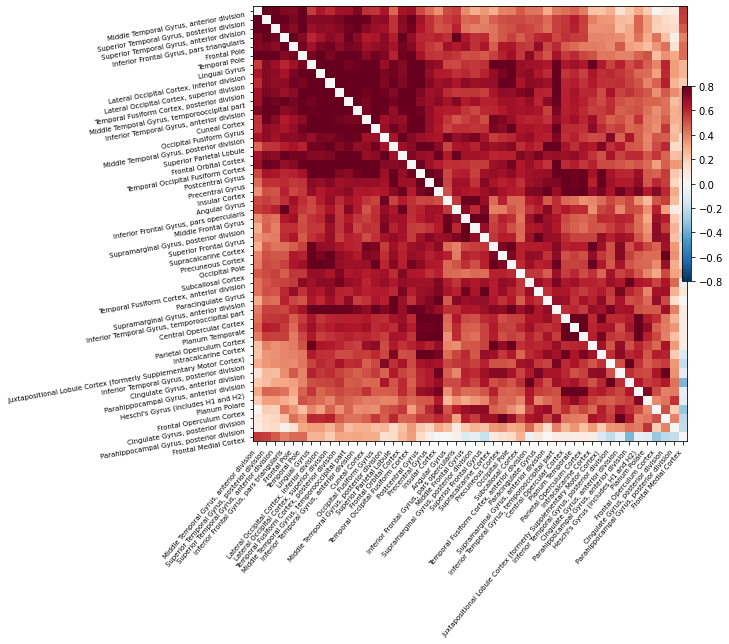

In [12]:
for time_series in time_series_list:
    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]

    # Plot the correlation matrix
    # Make a large figure
    # Mask the main diagonal for visualization:
    np.fill_diagonal(correlation_matrix, 0)
    # The labels we have start with the background (0), hence we skip the
    # first label
    # matrices are ordered for block-like representation
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=0.8, vmin=-0.8, reorder=True)

## Classification for Connectivity

In [13]:
# for now, we just use "correlation"
# kinds_of_matrix_correlation = ['correlation', 'partial correlation', 'tangent']
kinds_of_matrix_correlation = ['correlation', 'partial correlation', 'tangent']

# classes: "0" is ses-1, "1" is ses-2
_, classes = np.unique(groups, return_inverse=True)

# define cross-validation strategy here
cv = StratifiedShuffleSplit(n_splits=15, random_state=0, test_size=5)

# convert list into numpy array
time_series_numpy_array = np.asarray(time_series_list)

# scores
scores = {}

C:\Users\alexf\Anaconda3\envs\CSML1030\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
for kind_of_matrix_correlation in kinds_of_matrix_correlation:
    scores[kind_of_matrix_correlation] = []
    
    for train, test in cv.split(time_series_numpy_array, classes):
        # vectorize turns it into a 1D array
        connectivity = ConnectivityMeasure(kind=kind_of_matrix_correlation, vectorize=True)
        
        #calculate vectorized connectome for training set
        connectomes = connectivity.fit_transform(time_series_numpy_array[train])
        #print(len(connectomes))
        #print(len(classes[train]))
        
        #fit classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        
        predictions = classifier.predict(
            connectivity.transform(time_series_numpy_array[test]))
        
        # store the accuracy for this cross-validation fold
        scores[kind_of_matrix_correlation].append(accuracy_score(classes[test], predictions))

In [16]:
mean_scores = [np.mean(scores[kind_of_matrix_correlation]) for kind_of_matrix_correlation in kinds_of_matrix_correlation]
scores_std = [np.std(scores[kind_of_matrix_correlation]) for kind_of_matrix_correlation in kinds_of_matrix_correlation]

In [19]:
kinds_of_matrix_correlation

['correlation', 'partial correlation', 'tangent']

In [17]:
mean_scores

[0.7600000000000001, 0.6666666666666666, 0.8400000000000002]

In [18]:
scores_std

[0.14966629547095767, 0.20221001184137466, 0.1083205120618128]

In [22]:
results_df = pd.DataFrame(list(zip(kinds_of_matrix_correlation, mean_scores, scores_std)), columns = ['Kind of correlation', 'mean_scores', 'scores_std'])

In [23]:
results_df

,Kind of correlation,mean_scores,scores_std
0,correlation,0.760000,0.149666
1,partial correlation,0.666667,0.202210
2,tangent,0.840000,0.108321


In [24]:
results_df.to_csv('test_classification_of_functional_connectivity_between_roi_results.csv')